In [ ]:
# !python -m pip install --upgrade pip

In [ ]:
# !python -m pip install diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

# 设置运行环境,默认为cuda,若cuda不可用则改为mps,若mps也不可用则改为cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using device:{device}')

Using device:cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 4, 9, 6, 4, 7, 4, 7])


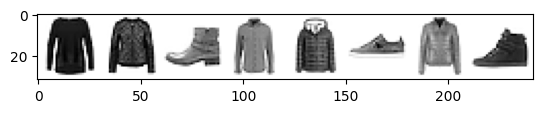

In [3]:
dataset = torchvision.datasets.FashionMNIST(root="./FashionMNIST/", train=True, download=True,
                                            transform=torchvision.transforms.ToTensor())  #载入数据集
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  #设置数据加载器
x, y = next(iter(train_dataloader))  #取出1个batch的图像和标签
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")  #用plt展示每个batch图像组成的网格

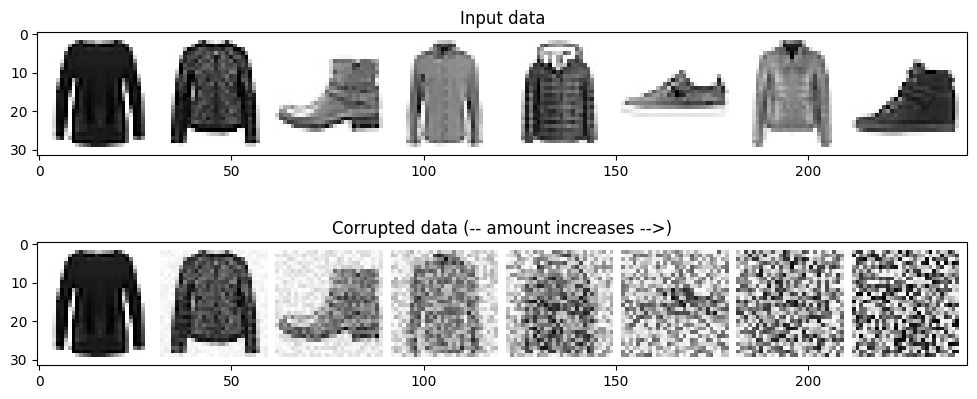

In [4]:
def corrupt(x, amount):
    """根据amount为输入x加入噪声,这就是退化过程"""
    noise = torch.rand_like(x)  #随机生成和图像大小一致的噪声
    amount = amount.view(-1, 1, 1, 1)  #整理形状以保证广播机制不出错,-1代表自动计算
    noisy_x = x * (1 - amount) + noise * amount  #计算输出结果
    return noisy_x


# 绘制输入数据
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))  #nrows表示行数,ncols表示列数,figsize表示窗口大小
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# 加入噪声
amount = torch.linspace(0, 1, x.shape[0])  #在[0,1]之间取8个点以表示8个强度的噪声
noised_x = corrupt(x, amount)  #加噪

# 绘制加噪版本的图像
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [19]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                                          nn.Conv2d(32, 64, kernel_size=5, padding=2),
                                          nn.Conv2d(64, 64, kernel_size=5, padding=2)
                                          ])
        self.up_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=5, padding=2),
                                        nn.Conv2d(64, 32, kernel_size=5, padding=2),
                                        nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
                                        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))
        return x

In [20]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [21]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch0.Average loss for this epoch:0.032561
Finished epoch1.Average loss for this epoch:0.024412
Finished epoch2.Average loss for this epoch:0.022010


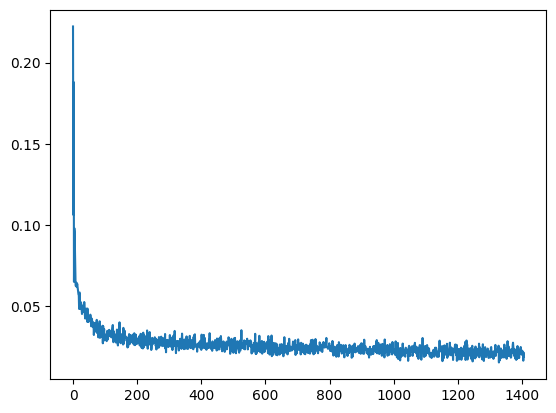

In [22]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)

        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished epoch{epoch}.Average loss for this epoch:{avg_loss:05f}")

plt.plot(losses)
plt.show()

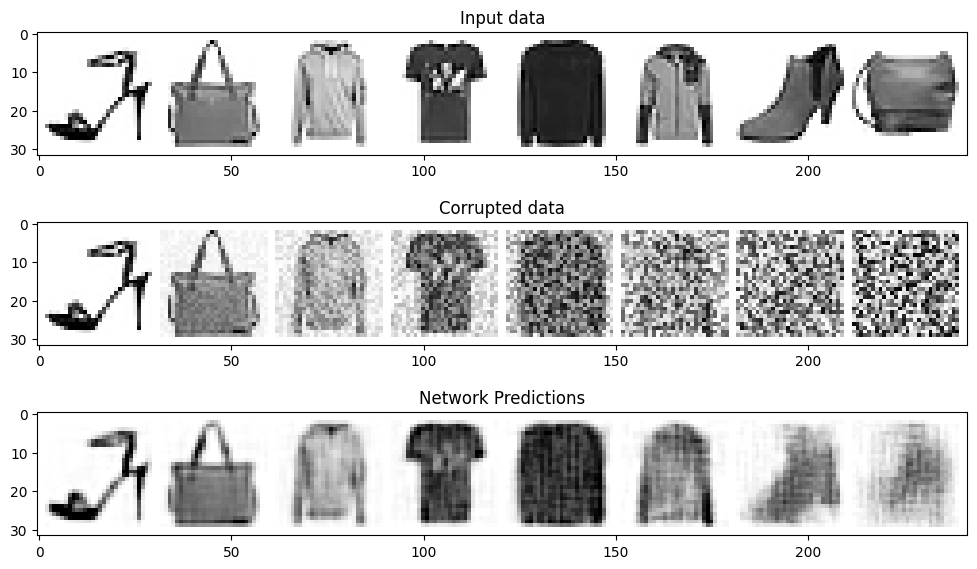

In [23]:
x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():  #去推理时不需要考虑张量的导数
    preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

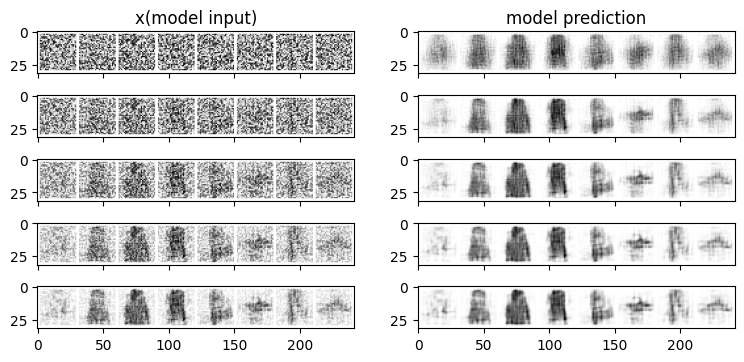

In [24]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)  #设置朝着预测方向移动多少
    x=x*(1-mix_factor)+pred*mix_factor
    step_history.append(x.detach().cpu())
    
fig,axs=plt.subplots(n_steps,2,figsize=(9,4),sharex=True)
axs[0,0].set_title("x(model input)")
axs[0,1].set_title("model prediction")
for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1),cmap="Greys")
    axs[i,1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1),cmap="Greys")
